## An introduction to the DataFrames.jl package

[Bogumił Kamiński](http://bogumilkaminski.pl/about/)

*version: 2021-07-18* for DataFrames v1.2.0 and Julia v1.6.1

This is a hands-on tutorial and does not intend to cover the details of the internals.

Also we do not try to achieve maximum performance, but show how one can simply do typical tasks.

### The packages used in the tutorial

installed packages

In [1]:
using DataFrames        # core package
using CSV               # working with CSV files
using FreqTables        # frequency tables
using Plots, StatsPlots # plotting
using GLM               # regression models

in-built modules

In [2]:
using Statistics, Serialization

Let us make sure we use the same versions of the packages. You should see the following output:
```
 (name = "StatsPlots", version = v"0.14.25")
 (name = "FreqTables", version = v"0.4.4")
 (name = "CSV", version = v"0.8.5")
 (name = "GLM", version = v"1.5.1")
 (name = "DataFrames", version = v"1.2.0")
 (name = "Plots", version = v"1.19.2")
```

In [3]:
using Pkg

In [4]:
versions = [(name=pkg.name, version=pkg.version)
            for pkg in values(Pkg.dependencies())
            if pkg.name in ["DataFrames", "CSV", "FreqTables", "Plots", "StatsPlots", "GLM"]]

6-element Vector{NamedTuple{(:name, :version), Tuple{String, VersionNumber}}}:
 (name = "StatsPlots", version = v"0.14.25")
 (name = "FreqTables", version = v"0.4.4")
 (name = "CSV", version = v"0.8.5")
 (name = "GLM", version = v"1.5.1")
 (name = "DataFrames", version = v"1.2.0")
 (name = "Plots", version = v"1.19.2")

It is time for a first encounter with a `DataFrame`

In [5]:
versions_df = DataFrame(versions)

,name,version
,String,Version…
1,StatsPlots,0.14.25
2,FreqTables,0.4.4
3,CSV,0.8.5
4,GLM,1.5.1
5,DataFrames,1.2.0
6,Plots,1.19.2


Sort the data frame by by package names in place:

In [6]:
sort!(versions_df, :name)

,name,version
,String,Version…
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


Let us play with it a bit - just to get a feeling. First grab one column from it without copying

In [7]:
versions_df.name

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

In [8]:
versions_df[!, :name]

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

In [9]:
versions_df[!, 1]

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

or copy it as a freshly allocated vector.

In [10]:
versions_df[:, :name]

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

In [11]:
versions_df[:, 1]

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

you can also use strings instead of `Symbol`s for column indexing

In [12]:
versions_df."name"

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

In [13]:
versions_df[:, "name"]

6-element Vector{String}:
 "CSV"
 "DataFrames"
 "FreqTables"
 "GLM"
 "Plots"
 "StatsPlots"

Now grab one row. This ia a view into a data frame.

In [14]:
versions_df[1, :]

,name,version
,String,Version…
1,CSV,0.8.5


Some people like to work with `NamedTuple`s

In [15]:
copy(versions_df[1, :])

(name = "CSV", version = v"0.8.5")

We can go back to the original `versions` variable like this

In [16]:
copy.(eachrow(versions_df))

6-element Vector{NamedTuple{(:name, :version), Tuple{String, VersionNumber}}}:
 (name = "CSV", version = v"0.8.5")
 (name = "DataFrames", version = v"1.2.0")
 (name = "FreqTables", version = v"0.4.4")
 (name = "GLM", version = v"1.5.1")
 (name = "Plots", version = v"1.19.2")
 (name = "StatsPlots", version = v"0.14.25")

or like this

In [17]:
Tables.rowtable(versions_df)

6-element Vector{NamedTuple{(:name, :version), Tuple{String, VersionNumber}}}:
 (name = "CSV", version = v"0.8.5")
 (name = "DataFrames", version = v"1.2.0")
 (name = "FreqTables", version = v"0.4.4")
 (name = "GLM", version = v"1.5.1")
 (name = "Plots", version = v"1.19.2")
 (name = "StatsPlots", version = v"0.14.25")

We can also fetch data columnwise into a `NamedTuple` of vectors:

In [18]:
Tables.columntable(versions_df)

(name = ["CSV", "DataFrames", "FreqTables", "GLM", "Plots", "StatsPlots"], version = VersionNumber[v"0.8.5", v"1.2.0", v"0.4.4", v"1.5.1", v"1.19.2", v"0.14.25"])

Now we want to get a single cell. We do it in several ways again (just to get comfortable with indexing syntax).

In [19]:
versions_df[1, 2], versions_df.version[1], versions_df[1, :version]

(v"0.8.5", v"0.8.5", v"0.8.5")

You can also convert your data frame into a `Matrix` (this is most useful when you have numeric data only)

In [20]:
mat = Matrix(versions_df)

6×2 Matrix{Any}:
 "CSV"         v"0.8.5"
 "DataFrames"  v"1.2.0"
 "FreqTables"  v"0.4.4"
 "GLM"         v"1.5.1"
 "Plots"       v"1.19.2"
 "StatsPlots"  v"0.14.25"

The conversion back to a data frame from a matrix is also possible:

In [21]:
DataFrame(mat, :auto)

,x1,x2
,Any,Any
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


Unfortunately it looses column names and column types information.

First let us fix the column names

In [22]:
temp_df = DataFrame(mat, [:name, :version])

,name,version
,Any,Any
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


we can also easily create a new `DataFrame` with correct element types:

In [23]:
DataFrame([[x for x in col] for col in eachcol(temp_df)], names(temp_df))

,name,version
,String,Version…
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


or (by the way note the effect of broadcasting `identity` over a vector)

In [24]:
DataFrame([identity.(col) for col in eachcol(mat)], [:name, :version])

,name,version
,String,Version…
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


or just

In [25]:
identity.(temp_df)

,name,version
,String,Version…
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


Alternatively we can fix column types in place (and practice Julia a bit more)

In [26]:
foreach(pairs(eachcol(temp_df))) do (name, col)
    temp_df[!, name] = identity.(col)
end

In [27]:
temp_df

,name,version
,String,Version…
1,CSV,0.8.5
2,DataFrames,1.2.0
3,FreqTables,0.4.4
4,GLM,1.5.1
5,Plots,1.19.2
6,StatsPlots,0.14.25


### Reading in a basic CSV file

Most likely you will want to read in the data from some external source, and typically (like it or not) it will be a CSV file.

We will work with data described and provided [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). I have included the source file in the repository of the tutorial to simplify things.

The classification goal is to predict if the client will subscribe a term deposit (variable `:y`).

In [28]:
bank = CSV.File("bank-additional-full.csv") |> DataFrame

,age,job,marital,education,default,housing,loan
,Int64,String,String,String,String,String,String
1,56,housemaid,married,basic.4y,no,no,no
2,57,services,married,high.school,unknown,no,no
3,37,services,married,high.school,no,yes,no
4,40,admin.,married,basic.6y,no,no,no
5,56,services,married,high.school,no,no,yes
6,45,services,married,basic.9y,unknown,no,no
7,59,admin.,married,professional.course,no,no,no
8,41,blue-collar,married,unknown,unknown,no,no
9,24,technician,single,professional.course,no,yes,no


You can adjust the number of rows/character columns printed as follows.

In [29]:
ENV["COLUMNS"] = 300;
ENV["LINES"] = 20;

In [30]:
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,Int64,String,String,String,String,String,String,String,String,String,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Some useful facts are that when displaying a data frame you get an information about its size on top and element types contained in its columns just under column names.

It is equally easy to save the data frame back to a CSV file.

In [31]:
CSV.write("newfile.txt", bank)

"newfile.txt"

Let us make sure that all is saved correctly.

In [32]:
CSV.read("newfile.txt", DataFrame) == bank

true

The beauty of the CSV.jl package is that it does autodetection of delimiters. Actually the original file used `;` while our newly created file used `,` (we could change this but `,` stantds for C in CSV so this is the default). Below we inspect both files visually.

In [33]:
readlines("bank-additional-full.csv")[1:3]

3-element Vector{String}:
 "\"age\";\"job\";\"marital\";\"education\";\"default\";\"housing\";\"loan\";\"contact\";\"month\";\"day_of_week\";\"duration\";\"campaign\";\"pdays\";\"previous\";\"poutcome\";\"emp.var.rate\";\"cons.price.idx\";\"cons.conf.idx\";\"euribor3m\";\"nr.employed\";\"y\""
 "56;\"housemaid\";\"married\";\"basic.4y\";\"no\";\"no\";\"no\";\"telephone\";\"may\";\"mon\";261;1;999;0;\"nonexistent\";1.1;93.994;-36.4;4.857;5191;\"no\""
 "57;\"services\";\"married\";\"high.school\";\"unknown\";\"no\";\"no\";\"telephone\";\"may\";\"mon\";149;1;999;0;\"nonexistent\";1.1;93.994;-36.4;4.857;5191;\"no\""

Let us get rid of these `\"` quotes as they add much visual noise

In [34]:
replace.(readlines("bank-additional-full.csv")[1:3], Ref("\""=>""))

3-element Vector{String}:
 "age;job;marital;education;default;housing;loan;contact;month;day_of_week;duration;campaign;pdays;previous;poutcome;emp.var.rate;cons.price.idx;cons.conf.idx;euribor3m;nr.employed;y"
 "56;housemaid;married;basic.4y;no;no;no;telephone;may;mon;261;1;999;0;nonexistent;1.1;93.994;-36.4;4.857;5191;no"
 "57;services;married;high.school;unknown;no;no;telephone;may;mon;149;1;999;0;nonexistent;1.1;93.994;-36.4;4.857;5191;no"

In [35]:
readlines("newfile.txt")[1:3]

3-element Vector{String}:
 "age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y"
 "56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no"
 "57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no"

We will not need `newfile.txt` so let us remove it.

In [36]:
rm("newfile.txt")

### Your first steps with `DataFrame`

Jou can get a list of names in a data frame as strings using the `names` function.

In [37]:
names(bank)

21-element Vector{String}:
 "age"
 "job"
 "marital"
 "education"
 "default"
 "housing"
 "loan"
 "contact"
 ⋮
 "poutcome"
 "emp.var.rate"
 "cons.price.idx"
 "cons.conf.idx"
 "euribor3m"
 "nr.employed"
 "y"

alternatively if you wanted to get column names as `Symbol`s write:

In [38]:
propertynames(bank)

21-element Vector{Symbol}:
 :age
 :job
 :marital
 :education
 :default
 :housing
 :loan
 :contact
 ⋮
 :poutcome
 Symbol("emp.var.rate")
 Symbol("cons.price.idx")
 Symbol("cons.conf.idx")
 :euribor3m
 Symbol("nr.employed")
 :y

The strange looking `Symbol` entries inform you that the column name was non-standard (contained a `.` in this case). For such columns it is actually easiest to select them by using their name passed as a string.

In [39]:
bank[!, "cons.conf.idx"]

41188-element Vector{Float64}:
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
   ⋮
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8

You might have noticed that DataFrames.jl uses a non-stantard `!` for row indexing. Here is a quick summary of the rules for getting data from a data frame:
* `df[!, :col]` and `df.col`: get a column `:col` from a data frame as a vector without copying
* `df[:, :col]` get a column `:col` from a data frame as a vector with copying
* `df[!, columns]` and `select(df, columns, copycols=false)`: get a new data frame with `columns` selected without copying the underlying data
* `df[:, columns]` and `select(df, columns)`: get a new data frame with `columns` selected with copying the underlying data

You can also take a subset of columns from a `DataFrame` "in place" using the `select!` function.

Our data frame looks a bit large. Let us subset it.

In [40]:
bank2 = select(bank, [:y, :age, :campaign, :pdays])

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,56,1,999
2,no,57,1,999
3,no,37,1,999
4,no,40,1,999
5,no,56,1,999
6,no,45,1,999
7,no,59,1,999
8,no,41,1,999
9,no,24,1,999


You can also use regular expressions as column selector. Here we take all columns that contain `"cons"` string:

In [41]:
select(bank, r"cons")

,cons.price.idx,cons.conf.idx
,Float64,Float64
1,93.994,-36.4
2,93.994,-36.4
3,93.994,-36.4
4,93.994,-36.4
5,93.994,-36.4
6,93.994,-36.4
7,93.994,-36.4
8,93.994,-36.4
9,93.994,-36.4


Going back to `bank2` data frame we notice that there is some strange `999` value in the last column. Let us investigate this.

In [42]:
describe(bank2)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,y,,no,,yes,0,String
2,age,40.0241,17,38.0,98,0,Int64
3,campaign,2.56759,1,2.0,56,0,Int64
4,pdays,962.475,0,999.0,999,0,Int64


(notice that the result is also a `DataFrame`, so you can work with it programatically in the future if you want)

We can inspect the contents of the column in more detail using a FreqTables.jl package

In [43]:
freqtable(bank2, :pdays)

27-element Named Vector{Int64}
pdays  │ 
───────┼──────
0      │    15
1      │    26
2      │    61
3      │   439
4      │   118
5      │    46
⋮            ⋮
21     │     2
22     │     3
25     │     1
26     │     1
27     │     1
999    │ 39673

In [44]:
proptable(bank2, :pdays)

27-element Named Vector{Float64}
pdays  │ 
───────┼────────────
0      │ 0.000364184
1      │ 0.000631252
2      │  0.00148101
3      │   0.0106584
4      │  0.00286491
5      │  0.00111683
⋮                  ⋮
21     │  4.85578e-5
22     │  7.28367e-5
25     │  2.42789e-5
26     │  2.42789e-5
27     │  2.42789e-5
999    │    0.963217

Alternatively we could have used split-apply-combine strategy to get a similar result:

In [45]:
combine(groupby(bank2, :pdays, sort=true), nrow)

,pdays,nrow
,Int64,Int64
1,0,15
2,1,26
3,2,61
4,3,439
5,4,118
6,5,46
7,6,412
8,7,60
9,8,18


It turns out that `999` means that the client was never contacted by a bank before (see https://archive.ics.uci.edu/ml/datasets/bank+marketing for a description of the data set)

Assume we want to work only with customers who were contacted previously. We can filter `bank2` data frame.

In [46]:
bank3 = filter(:pdays => !=(999), bank2)

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,37,1,6
2,no,48,1,4
3,no,42,1,4
4,no,50,1,3
5,no,36,2,4
6,yes,32,2,5
7,no,31,1,5
8,no,51,2,1
9,no,52,1,6


Here are some other options that do the same (just as an exercise)

In [47]:
bank2[bank2.pdays .!= 999, :]

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,37,1,6
2,no,48,1,4
3,no,42,1,4
4,no,50,1,3
5,no,36,2,4
6,yes,32,2,5
7,no,31,1,5
8,no,51,2,1
9,no,52,1,6


In [48]:
bank2[Not(bank2.pdays .== 999), :]

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,37,1,6
2,no,48,1,4
3,no,42,1,4
4,no,50,1,3
5,no,36,2,4
6,yes,32,2,5
7,no,31,1,5
8,no,51,2,1
9,no,52,1,6


In the last example note that DataFrames.jl supports `Not` from InvertedIndices.jl (both for rows and for columns selection).

One might ask if the data is correlated in `bank3` data frame. It is easy to check.

Recode variable `y` to be binary. Let us first make sure that it is binary indeed.

In [49]:
combine(groupby(bank3, :y), nrow)

,y,nrow
,String,Int64
1,no,548
2,yes,967


OK - it is safe to recode it.

In [50]:
using CategoricalArrays

In [51]:
bank3.y_bin = recode(bank3.y, "no"=>0, "yes"=>1)

1515-element Vector{Int64}:
 0
 0
 0
 0
 0
 1
 0
 0
 ⋮
 1
 0
 1
 1
 1
 1
 0

Always double check if you got what you wanted. We will do it in several ways.

In [52]:
freqtable(bank3, :y, :y_bin)

2×2 Named Matrix{Int64}
y ╲ y_bin │   0    1
──────────┼─────────
no        │ 548    0
yes       │   0  967

In [53]:
combine(groupby(bank3, [:y, :y_bin]), nrow)

,y,y_bin,nrow
,String,Int64,Int64
1,no,0,548
2,yes,1,967


below we use the form in which `combine` takes a function as a first argument. Note that in this case it is allowed to return multiple columns from the aggregation operation (we return `NamedTuple` in the first example and a `DataFrame` in the second one).

In [54]:
combine(groupby(bank3, :y)) do sdf
    return (y_bin_0 = count(==(0), sdf.y_bin), y_bin_1 = count(==(1), sdf.y_bin))
end

,y,y_bin_0,y_bin_1
,String,Int64,Int64
1,no,548,0
2,yes,0,967


In [55]:
crosstable = combine(groupby(bank3, :y)) do sdf
    return DataFrame([[count(==(i), sdf.y_bin)] for i in 0:1], string.(0:1))
end

,y,0,1
,String,Int64,Int64
1,no,548,0
2,yes,0,967


Let us try getting something similar we got in the first approach as an exercise of using `stack`. Observe that such column names as `"0"` and `"1"` are not a problem as we are allowed to refer to them using strings.

In [56]:
crosstable2 = stack(crosstable, ["0", "1"])

,y,variable,value
,String,String,Int64
1,no,0,548
2,yes,0,0
3,no,1,0
4,yes,1,967


What if we do not like the naming of variables in this table?

In [57]:
rename!(crosstable2, :variable=>:y_bin, :value=>:nrow)

,y,y_bin,nrow
,String,String,Int64
1,no,0,548
2,yes,0,0
3,no,1,0
4,yes,1,967


we could have done this in one shot

In [58]:
stack(crosstable, ["0", "1"], variable_name=:y_bin, value_name=:nrow)

,y,y_bin,nrow
,String,String,Int64
1,no,0,548
2,yes,0,0
3,no,1,0
4,yes,1,967


Note that `:y_bin` column is categorical - let us make it an integer.

In [59]:
crosstable2.y_bin = parse.(Int, string.(crosstable2.y_bin))

4-element Vector{Int64}:
 0
 0
 1
 1

In [60]:
filter(:nrow => !=(0),crosstable2)

,y,y_bin,nrow
,String,Int64,Int64
1,no,0,548
2,yes,1,967


back to the correlation analysis ...

this is the simplest approach

In [61]:
cor(Matrix(bank3[!,Not(:y)]))

4×4 Matrix{Float64}:
  1.0          0.00495337  -0.069608    0.0702834
  0.00495337   1.0          0.0457519  -0.125418
 -0.069608     0.0457519    1.0        -0.0352235
  0.0702834   -0.125418    -0.0352235   1.0

here we use a fact that `DataFrame` can be created from a vector of `NamedTuple`s

In [62]:
cor2 = DataFrame([(var1=names(bank3)[i],
                   var2=names(bank3)[j],
                   cor=cor(bank3[!, i], bank3[!, j])) for i in 2:ncol(bank3) for j in 2:ncol(bank3)])

,var1,var2,cor
,String,String,Float64
1,age,age,1.0
2,age,campaign,0.00495337
3,age,pdays,-0.069608
4,age,y_bin,0.0702834
5,campaign,age,0.00495337
6,campaign,campaign,1.0
7,campaign,pdays,0.0457519
8,campaign,y_bin,-0.125418
9,pdays,age,-0.069608


now we can `unstack` it to get a `DataFrame` that is similar to the matrix above:

In [63]:
cor3 = unstack(cor2, :var2, :cor)

,var1,age,campaign,pdays,y_bin
,String,Float64?,Float64?,Float64?,Float64?
1,age,1.0,0.00495337,-0.069608,0.0702834
2,campaign,0.00495337,1.0,0.0457519,-0.125418
3,pdays,-0.069608,0.0457519,1.0,-0.0352235
4,y_bin,0.0702834,-0.125418,-0.0352235,1.0


Sometimes you want to store your data frame exactly as it stands (e.g. storing all column type information exactly or if you have some non-standard data types, e.g. vectors).

In such case storing it as a CSV file is not enough. The simplest option is to use serialization. This is a fast approach. Its only drawback is that it assumes that the data will be read on the same configuration of the machine, Julia and the packages as it were written (this is a low level binary representation of your data).

Let us first add a non-standard column to our data frame.

In [64]:
transform!(cor3, AsTable(Not(:var1)) => ByRow(extrema) => :extrema)

,var1,age,campaign,pdays,y_bin,extrema
,String,Float64?,Float64?,Float64?,Float64?,Tuple…
1,age,1.0,0.00495337,-0.069608,0.0702834,"(-0.069608, 1.0)"
2,campaign,0.00495337,1.0,0.0457519,-0.125418,"(-0.125418, 1.0)"
3,pdays,-0.069608,0.0457519,1.0,-0.0352235,"(-0.069608, 1.0)"
4,y_bin,0.0702834,-0.125418,-0.0352235,1.0,"(-0.125418, 1.0)"


In [65]:
serialize("cor3.bin", cor3)

In [66]:
cor3′ = deserialize("cor3.bin")

,var1,age,campaign,pdays,y_bin,extrema
,String,Float64?,Float64?,Float64?,Float64?,Tuple…
1,age,1.0,0.00495337,-0.069608,0.0702834,"(-0.069608, 1.0)"
2,campaign,0.00495337,1.0,0.0457519,-0.125418,"(-0.125418, 1.0)"
3,pdays,-0.069608,0.0457519,1.0,-0.0352235,"(-0.069608, 1.0)"
4,y_bin,0.0702834,-0.125418,-0.0352235,1.0,"(-0.125418, 1.0)"


In [67]:
cor3 == cor3′

true

Note that:
1. column types of `:age`, `:campaign`, `:pdays`, and `:y_bin` allow missing (as in the source).
2. column `:extrema` stores tuples.

If we stored it in a CSV file and loaded it back we would loose this information.

In [68]:
CSV.write("cor3.csv", cor3)

"cor3.csv"

In [69]:
CSV.read("cor3.csv", DataFrame)

,var1,age,campaign,pdays,y_bin,extrema
,String,Float64,Float64,Float64,Float64,String
1,age,1.0,0.00495337,-0.069608,0.0702834,"(-0.06960797510250025, 0.9999999999999999)"
2,campaign,0.00495337,1.0,0.0457519,-0.125418,"(-0.12541792500695081, 1.0)"
3,pdays,-0.069608,0.0457519,1.0,-0.0352235,"(-0.06960797510250025, 1.0)"
4,y_bin,0.0702834,-0.125418,-0.0352235,1.0,"(-0.12541792500695081, 1.0)"


Let us clean up the temporary files we have created.

In [70]:
rm("cor3.bin")

In [71]:
rm("cor3.csv")

## Handling missing data

Let us go back to our `bank2` data frame.

In [72]:
bank2

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,56,1,999
2,no,57,1,999
3,no,37,1,999
4,no,40,1,999
5,no,56,1,999
6,no,45,1,999
7,no,59,1,999
8,no,41,1,999
9,no,24,1,999


We know that if `:pdays` is `999` then it is a missing value. We can perform the conversion in several ways.

In [73]:
bank2.pdays2 = replace(bank2.pdays, 999=>missing)

41188-element Vector{Union{Missing, Int64}}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮
  missing
 9
  missing
  missing
  missing
  missing
  missing

In [74]:
freqtable(bank2.pdays .!= 999, bank2.pdays2 .!= missing)

2×1 Named Matrix{Int64}
Dim1 ╲ Dim2 │ missing
────────────┼────────
false       │   39673
true        │    1515

This is surprising. We can to better

In [75]:
freqtable(bank2.pdays .!= 999, isequal.(bank2.pdays2, missing))

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
false       │     0  39673
true        │  1515      0

Remember that `missing` usses three valued logic. The `isequal` and `isless` functions do not pass missing, other standard operators return missing if they encounter missing.

In [76]:
1 < missing

missing

In [77]:
isless(1, missing)

true

In [78]:
isless(Inf, missing)

true

by the way, it is good to remember that `missing` is larger than any real value in `isless` comparison.

Let us see another example to see that it matters.

In [79]:
filter(:pdays2 => ==(1), bank2)

LoadError: TypeError: non-boolean (Missing) used in boolean context

It is easy to fix it though.

In [80]:
filter(:pdays2 => isequal(1), bank2)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64,Int64?
1,no,51,2,1,1
2,no,50,3,1,1
3,no,26,1,1,1
4,no,34,1,1,1
5,no,37,2,1,1
6,no,45,1,1,1
7,no,48,2,1,1
8,no,27,1,1,1
9,yes,32,4,1,1


Sometimes you want to retain `missing` after filtering. This is the way to do it.

In [81]:
bank_tmp = filter(:pdays2 => x -> coalesce(x == 1, true), bank2)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64,Int64?
1,no,56,1,999,missing
2,no,57,1,999,missing
3,no,37,1,999,missing
4,no,40,1,999,missing
5,no,56,1,999,missing
6,no,45,1,999,missing
7,no,59,1,999,missing
8,no,41,1,999,missing
9,no,24,1,999,missing


But the table is long - how to make sure we have only `1` and `missing` in the `:pdays2` column?

In [82]:
freqtable(bank_tmp, :pdays2)

2-element Named Vector{Int64}
pdays2  │ 
────────┼──────
1       │    26
missing │ 39673

In [83]:
combine(groupby(bank_tmp, :pdays2), nrow)

,pdays2,nrow
,Int64?,Int64
1,1,26
2,missing,39673


Note that columns allowing missing values have a special `?` character printed by their element type information.

Also `describe` is useful in analyzing missing data.

In [84]:
describe(bank2)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,y,,no,,yes,0,String
2,age,40.0241,17,38.0,98,0,Int64
3,campaign,2.56759,1,2.0,56,0,Int64
4,pdays,962.475,0,999.0,999,0,Int64
5,pdays2,6.01452,0,6.0,27,39673,"Union{Missing, Int64}"


What if we wanted to change `:pdays` vector to allow missing values?

Initially it does not allow them.

In [85]:
bank2.pdays[1] = missing

LoadError: MethodError: [0mCannot `convert` an object of type [92mMissing[39m[0m to an object of type [91mInt64[39m
[0mClosest candidates are:
[0m  convert(::Type{S}, [91m::CategoricalValue[39m) where S<:Union{AbstractChar, AbstractString, Number} at C:\Users\bogum\.julia\packages\CategoricalArrays\rDwMt\src\value.jl:92
[0m  convert(::Type{T}, [91m::Ptr[39m) where T<:Integer at pointer.jl:23
[0m  convert(::Type{IT}, [91m::GeometryBasics.OffsetInteger[39m) where IT<:Integer at C:\Users\bogum\.julia\packages\GeometryBasics\pjtu1\src\offsetintegers.jl:40
[0m  ...

You have to change the type of the vector using the `allowmissing!` function.

In [86]:
allowmissing!(bank2, :pdays)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64?,Int64?
1,no,56,1,999,missing
2,no,57,1,999,missing
3,no,37,1,999,missing
4,no,40,1,999,missing
5,no,56,1,999,missing
6,no,45,1,999,missing
7,no,59,1,999,missing
8,no,41,1,999,missing
9,no,24,1,999,missing


Now you can assign `missing` to `:pdays` column.

In [87]:
replace!(bank2.pdays, 999 => missing)

41188-element Vector{Union{Missing, Int64}}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮
  missing
 9
  missing
  missing
  missing
  missing
  missing

In [88]:
describe(bank2)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,y,,no,,yes,0,String
2,age,40.0241,17,38.0,98,0,Int64
3,campaign,2.56759,1,2.0,56,0,Int64
4,pdays,6.01452,0,6.0,27,39673,"Union{Missing, Int64}"
5,pdays2,6.01452,0,6.0,27,39673,"Union{Missing, Int64}"


Again - let us check that it worked correctly.

In [89]:
bank2.pdays == bank2.pdays2

missing

We knew it would fail - right?

In [90]:
isequal(bank2.pdays, bank2.pdays2)

true

Often we want to get rid of missing data from a data frame. We can do this using the `dropmissing` function.

In [91]:
bank4 = dropmissing(bank2)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64,Int64
1,no,37,1,6,6
2,no,48,1,4,4
3,no,42,1,4,4
4,no,50,1,3,3
5,no,36,2,4,4
6,yes,32,2,5,5
7,no,31,1,5,5
8,no,51,2,1,1
9,no,52,1,6,6


Note that now columns automatically dicallow missing values.

Actually `bank4` should be the same as `bank3` on the first 4 columns. Let us check this.

In [92]:
bank3[!, 1:4] == bank4[!, 1:4]

true

## No tutorial is complete without plotting instructions

Let us first do some exploratory plotting

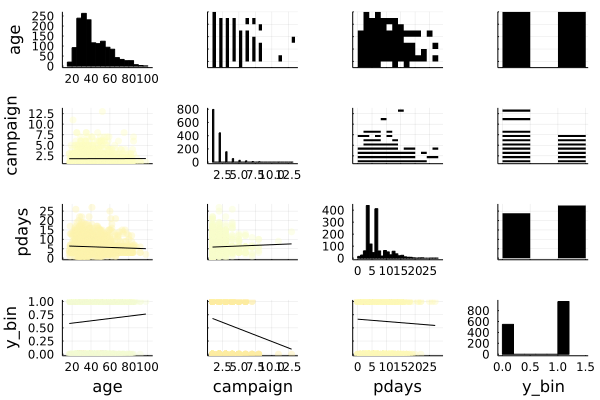

In [93]:
@df bank3 corrplot(cols(2:5))

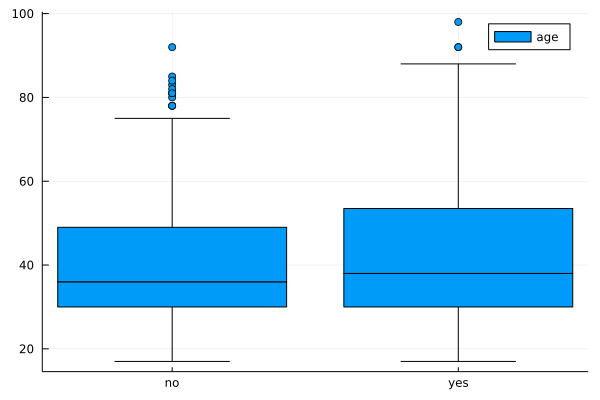

In [94]:
@df bank3 boxplot(:y, :age, label="age")

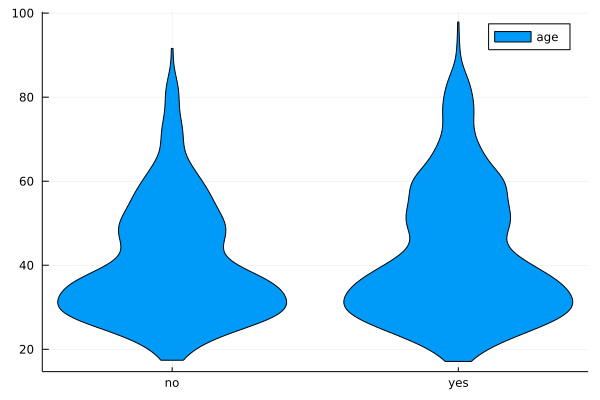

In [95]:
@df bank3 violin(:y, :age, label="age")

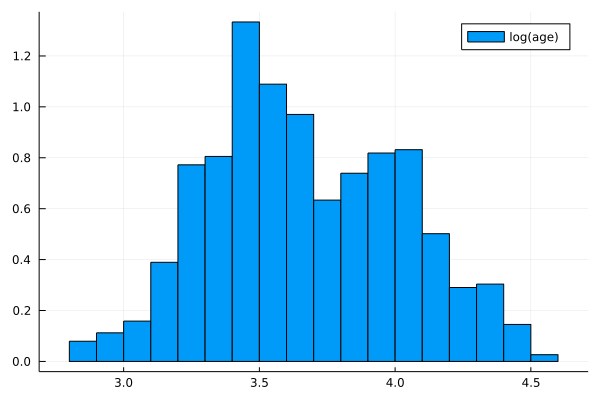

In [96]:
@df bank3 histogram(log.(:age), label="log(age)", normalize=true)

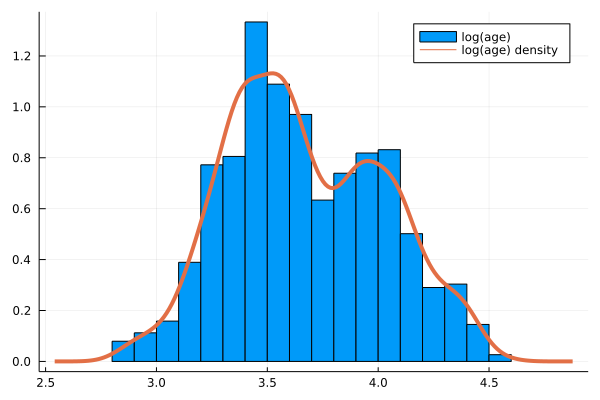

In [97]:
@df bank3 density!(log.(:age), linewidth=4, label="log(age) density")

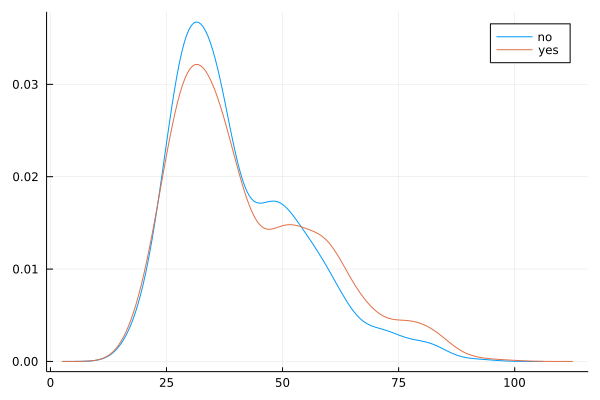

In [98]:
@df bank3 density(:age, group=:y)

## Categorical vairables

Sometimes you want to add to your columns the metadata that they are categorical.

In this section we discuss how you can do it and how this information is used by the `GLM` package as an application example.

Let us get back to our original `bank` data frame. We will want to build a model explaining `:y` using some other variables from the data set.

In [99]:
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,Int64,String,String,String,String,String,String,String,String,String,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [100]:
glm(@formula(y ~ age + day_of_week + campaign), bank, Binomial())

LoadError: MethodError: no method matching fit(::Type{GeneralizedLinearModel}, ::Matrix{Float64}, ::Matrix{Float64}, ::Binomial{Float64})
[0mClosest candidates are:
[0m  fit([91m::StatisticalModel[39m, ::Any...) at C:\Users\bogum\.julia\packages\StatsBase\DU1bT\src\statmodels.jl:178
[0m  fit(::Type{M}, ::Union{Matrix{T}, SparseArrays.SparseMatrixCSC{T, Ti} where Ti<:Integer}, [91m::AbstractVector{var"#s57"} where var"#s57"<:Real[39m, ::Distributions.UnivariateDistribution{S} where S<:Distributions.ValueSupport) where {M<:GLM.AbstractGLM, T<:AbstractFloat} at C:\Users\bogum\.julia\packages\GLM\5CcRd\src\glmfit.jl:467
[0m  fit(::Type{M}, ::Union{Matrix{T}, SparseArrays.SparseMatrixCSC{T, Ti} where Ti<:Integer}, [91m::AbstractVector{var"#s56"} where var"#s56"<:Real[39m, ::Distributions.UnivariateDistribution{S} where S<:Distributions.ValueSupport, [91m::Link[39m; dofit, wts, offset, fitargs...) where {M<:GLM.AbstractGLM, T<:AbstractFloat} at C:\Users\bogum\.julia\packages\GLM\5CcRd\src\glmfit.jl:467
[0m  ...

This failed, because the `GLM` package needs to know that `:y` is binary. Let us change this.

In [101]:
bank.y_bin = ifelse.(bank.y .== "yes", 1, 0)

41188-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 0
 1
 0
 0
 1
 0

In [102]:
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
,Int64,String,String,String,String,String,String,String,String,String,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String,Int64
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [103]:
glm(@formula(y_bin ~ age + day_of_week + campaign), bank, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_bin ~ 1 + age + day_of_week + campaign

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error       z  Pr(>|z|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)       -2.18369     0.0727297   -30.02    <1e-99  -2.32624     -2.04114
age                0.00916394  0.0014537     6.30    <1e-09   0.00631475   0.0120131
day_of_week: mon  -0.0986672   0.0514918    -1.92    0.0553  -0.199589     0.00225484
day_of_week: thu   0.115643    0.0493282     2.34    0.0191   0.018961     0.212324
day_of_week: tue   0.0670772   0.0503273     1.33    0.1826  -0.0315626    0.165717
day_of_week: wed   0.0672455   0.0503671     1.34  

This is not very nice as `day_of_week` is not properly ordered. Fortunately it is easy to change this.

In [104]:
transform!(bank, :day_of_week => categorical, renamecols=false)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
,Int64,String,String,String,String,String,String,String,String,Cat…,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String,Int64
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [105]:
levels(bank.day_of_week)

5-element Vector{String}:
 "fri"
 "mon"
 "thu"
 "tue"
 "wed"

In [106]:
levels!(bank.day_of_week, ["mon", "tue", "wed", "thu", "fri"]);

Now the order of levels should be correct.

In [107]:
glm(@formula(y_bin ~ age + day_of_week + campaign), bank, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_bin ~ 1 + age + day_of_week + campaign

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)       -2.28236     0.0728343   -31.34    <1e-99  -2.42511     -2.1396
age                0.00916394  0.0014537     6.30    <1e-09   0.00631475   0.0120131
day_of_week: tue   0.165744    0.0501678     3.30    0.0010   0.0674174    0.264071
day_of_week: wed   0.165913    0.0502154     3.30    0.0010   0.0674924    0.264333
day_of_week: thu   0.21431     0.0491724     4.36    <1e-04   0.117934     0.310686
day_of_week: fri   0.0986672   0.0514918     1.92    0.05

Let us have a more detailed look at `:campaign` variable.

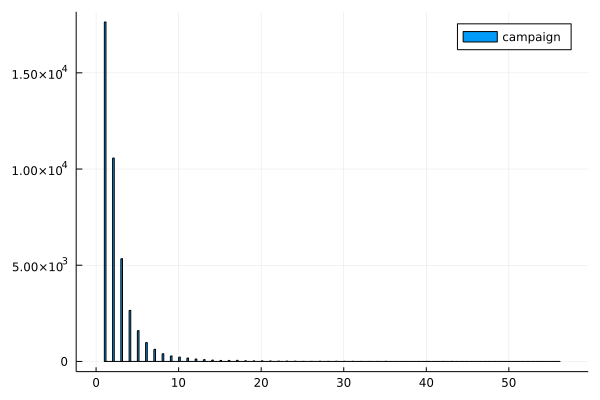

In [108]:
@df bank histogram(:campaign, label="campaign")

It is very skewed. We will cut it into several bins.

In [109]:
bank.campaign_cat = cut(bank.campaign, 1:4, extend=true)

41188-element CategoricalArray{String,1,UInt32}:
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 ⋮
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[2, 3)"
 "[1, 2)"
 "[3, 4)"

In [110]:
levels(bank.campaign_cat)

4-element Vector{String}:
 "[1, 2)"
 "[2, 3)"
 "[3, 4)"
 "[4, 56]"

In [111]:
proptable(bank.campaign_cat)

4-element Named Vector{Float64}
Dim1                                       │ 
───────────────────────────────────────────┼─────────
CategoricalValue{String, UInt32} "[1, 2)"  │ 0.428329
CategoricalValue{String, UInt32} "[2, 3)"  │ 0.256628
CategoricalValue{String, UInt32} "[3, 4)"  │ 0.129674
CategoricalValue{String, UInt32} "[4, 56]" │  0.18537

In [112]:
glm(@formula(y_bin ~ age + day_of_week + campaign_cat), bank, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_bin ~ 1 + age + day_of_week + campaign_cat

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            -2.39969     0.0723434   -33.17    <1e-99  -2.54148     -2.2579
age                     0.00912225  0.00145425    6.27    <1e-09   0.00627197   0.0119725
day_of_week: tue        0.16417     0.0502005     3.27    0.0011   0.0657788    0.262561
day_of_week: wed        0.162328    0.050238      3.23    0.0012   0.0638635    0.260793
day_of_week: thu        0.204475    0.0492072     4.16    <1e-04   0.10803      0.300919
day_of_week: 

Now let us investigate the `:age` variable.

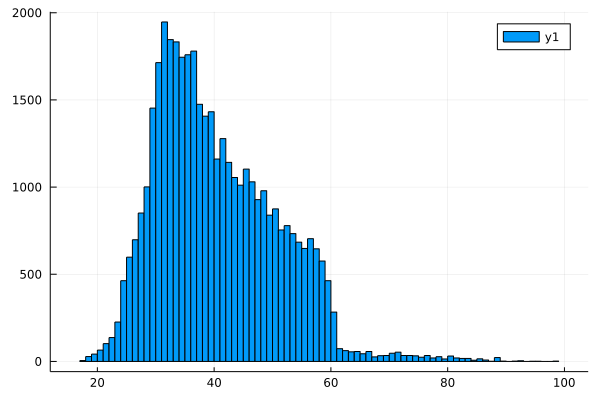

In [113]:
histogram(bank.age)

In [114]:
bank.age_cut = cut(bank.age, 10)

41188-element CategoricalArray{String,1,UInt32}:
 "Q10: [55.0, 98.0]"
 "Q10: [55.0, 98.0]"
 "Q5: [35.0, 38.0)"
 "Q6: [38.0, 41.0)"
 "Q10: [55.0, 98.0]"
 "Q8: [45.0, 49.0)"
 "Q10: [55.0, 98.0]"
 "Q7: [41.0, 45.0)"
 ⋮
 "Q5: [35.0, 38.0)"
 "Q2: [28.0, 31.0)"
 "Q10: [55.0, 98.0]"
 "Q8: [45.0, 49.0)"
 "Q10: [55.0, 98.0]"
 "Q7: [41.0, 45.0)"
 "Q10: [55.0, 98.0]"

In [115]:
y_by_age = combine(groupby(bank, :age_cut), :y_bin => mean => :mean_y_bin)

,age_cut,mean_y_bin
,Cat…,Float64
1,"Q1: [17.0, 28.0)",0.18196
2,"Q2: [28.0, 31.0)",0.129319
3,"Q3: [31.0, 33.0)",0.106512
4,"Q4: [33.0, 35.0)",0.110117
5,"Q5: [35.0, 38.0)",0.0913442
6,"Q6: [38.0, 41.0)",0.08525
7,"Q7: [41.0, 45.0)",0.0822559
8,"Q8: [45.0, 49.0)",0.0806931
9,"Q9: [49.0, 55.0)",0.0915523


In [116]:
y_by_age.age_cut = string.(y_by_age.age_cut)

10-element Vector{String}:
 "Q1: [17.0, 28.0)"
 "Q2: [28.0, 31.0)"
 "Q3: [31.0, 33.0)"
 "Q4: [33.0, 35.0)"
 "Q5: [35.0, 38.0)"
 "Q6: [38.0, 41.0)"
 "Q7: [41.0, 45.0)"
 "Q8: [45.0, 49.0)"
 "Q9: [49.0, 55.0)"
 "Q10: [55.0, 98.0]"

In [117]:
using Plots.Measures # we need this to specify larger bottom margin in points

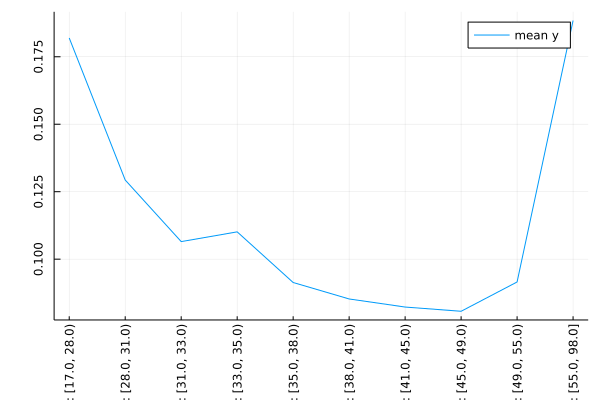

In [118]:
@df y_by_age plot(:age_cut, :mean_y_bin, label="mean y", rotation=90, bottom_margin=40pt)

It looks like our relationship is not linear. Let us add a quadratic term to the model.

In [119]:
bank.age2 = bank.age .^ 2

41188-element Vector{Int64}:
 3136
 3249
 1369
 1600
 3136
 2025
 3481
 1681
    ⋮
 1369
  841
 5329
 2116
 3136
 1936
 5476

In [120]:
model = glm(@formula(y_bin ~ age + age2 + day_of_week + campaign_cat), bank, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_bin ~ 1 + age + age2 + day_of_week + campaign_cat

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       z  Pr(>|z|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             1.90667     0.168144     11.34    <1e-29   1.57712      2.23623
age                    -0.194612    0.00752238  -25.87    <1e-99  -0.209356    -0.179869
age2                    0.00222718  8.16362e-5   27.28    <1e-99   0.00206718   0.00238719
day_of_week: tue        0.146174    0.0510021     2.87    0.0042   0.0462113    0.246136
day_of_week: wed        0.132466    0.0510235     2.60    0.0094   0.0324618    0.23247
da

or simply

In [121]:
glm(@formula(y_bin ~ age + age^2 + day_of_week + campaign_cat), bank, Binomial())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_bin ~ 1 + age + :(age ^ 2) + day_of_week + campaign_cat

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       z  Pr(>|z|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             1.90667     0.168144     11.34    <1e-29   1.57712      2.23623
age                    -0.194612    0.00752238  -25.87    <1e-99  -0.209356    -0.179869
age ^ 2                 0.00222718  8.16362e-5   27.28    <1e-99   0.00206718   0.00238719
day_of_week: tue        0.146174    0.0510021     2.87    0.0042   0.0462113    0.246136
day_of_week: wed        0.132466    0.0510235     2.60    0.0094   0.0324618    0.23

In [122]:
est = coef(model)

10-element Vector{Float64}:
  1.906672429720792
 -0.19461243455862878
  0.002227182537276545
  0.1461736252103279
  0.13246609237294774
  0.18347444563044296
  0.08949646535853645
 -0.1308791199461836
 -0.17296494557712888
 -0.609777307759692

In [123]:
-est[2]/(2*est[3])

43.690274887977026

And we now see that the minimum probability predicted by our model is at age of around 44 years.